In [1]:
from echolab2.instruments import EK60
from echolab2.plotting.matplotlib import echogram
import numpy as np
%matplotlib inline

In [4]:
ek60 = EK60.EK60()
ek60.read_raw("E:\\MACE\\\ExampleTargetData\\WBAT2_Outer_Mooring_EK60-WBAT-phase1-seq1168-0.RAW")
#ek60.read_raw("C:\\Users\\Robert\\Downloads\\DY1801_EK60-D20180211-T164025.RAW")
raw38kHz=ek60.get_raw_data(channel_number =1)
Sv38kHz=raw38kHz.get_Sv()
angles=raw38kHz.get_physical_angles()

{'type': 'CON0', 'low_date': 1336699136, 'high_date': 30377828, 'survey_name': 'DY1407', 'transect_name': '', 'sounder_name': 'ER60', 'version': '2.2.1', 'spare0': '', 'transceiver_count': 1, 'timestamp': datetime.datetime(2014, 6, 14, 0, 5, 12, 21221, tzinfo=<UTC>), 'transceivers': {1: {'channel_id': 'WBAT 123456-15-1', 'beam_type': 1, 'frequency': 70000.0, 'gain': 18.0, 'equivalent_beam_angle': -13.0, 'beamwidth_alongship': 18.0, 'beamwidth_athwartship': 18.0, 'angle_sensitivity_alongship': 10.0, 'angle_sensitivity_athwartship': 10.0, 'angle_offset_alongship': 0.0, 'angle_offset_athwartship': 0.0, 'pos_x': 0.0, 'pos_y': 0.0, 'pos_z': 0.0, 'dir_x': 0.0, 'dir_y': 0.0, 'dir_z': 0.0, 'pulse_length_table': array([0.000128, 0.000256, 0.000512, 0.001024, 0.002048]), 'spare1': '', 'gain_table': array([18., 18., 18., 18., 18.]), 'spare2': '', 'sa_correction_table': array([0., 0., 0., 0., 0.]), 'spare3': '', 'gpt_software_version': '', 'spare4': ''}}}
2014-06-14 00:05:12.021221+00:00
1
dict_ke

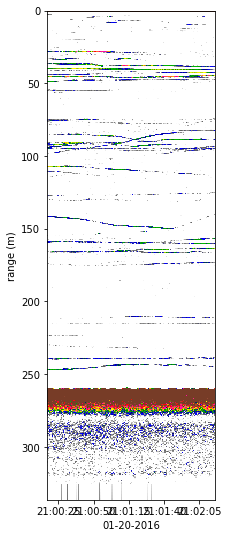

In [30]:
from matplotlib.pyplot import figure, show, subplots_adjust, get_cmap
fig =figure(figsize=(3,9))
#fig = figure()
ax = fig.add_subplot(1,1,1)
echogram_3 = echogram.echogram(ax, Sv38kHz, threshold=[-70,-34])
ax.grid(False)
show()

# Canny Filter

In [48]:
from skimage import feature
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

In [115]:
Trim100m = Sv38kHz.data[:,:np.min(np.where(Sv38kHz.range > 100))]

im = ndi.rotate(Trim100m, -90, mode='constant')

im[im < -70] = -999
im[im > -34] = -999
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)
edges3 = feature.canny(im, sigma=5)

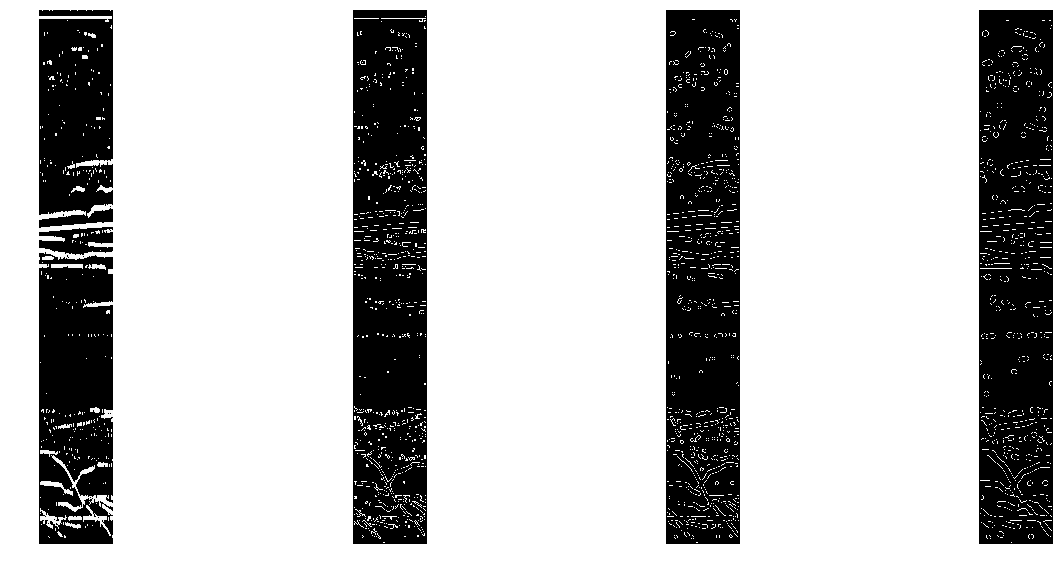

In [116]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20, 8),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
#ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
#ax2.set_title('Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
#ax3.set_title('Canny filter, $\sigma=3$', fontsize=20)

ax4.imshow(edges3, cmap=plt.cm.gray)
ax4.axis('off')
#ax4.set_title('Canny filter, $\sigma=5$', fontsize=20)

fig.tight_layout()

plt.show()

# Edge Detection

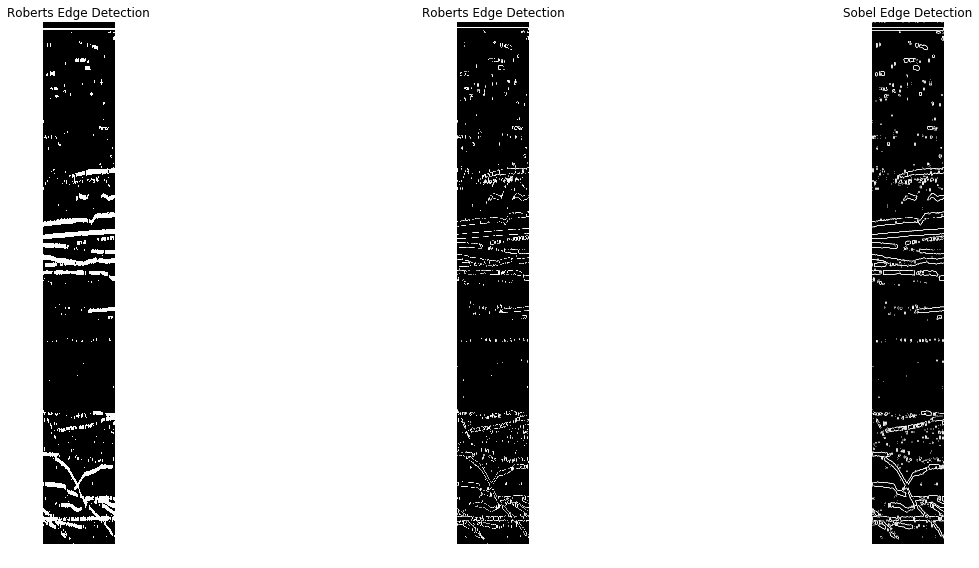

In [200]:
Trim100m = Sv38kHz.data[:,:np.min(np.where(Sv38kHz.range > 100))]

im = ndi.rotate(Trim100m, -90, mode='constant')

im[im < -70] = -999
im[im > -34] = -999

from skimage.filters import roberts, sobel, scharr, prewitt


image = im
edge_roberts = roberts(image)
edge_sobel = sobel(image)

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True,
                       figsize=(20, 8))

ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_roberts, cmap=plt.cm.gray)
ax[1].set_title('Roberts Edge Detection')

ax[2].imshow(edge_sobel, cmap=plt.cm.gray)
ax[2].set_title('Sobel Edge Detection')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

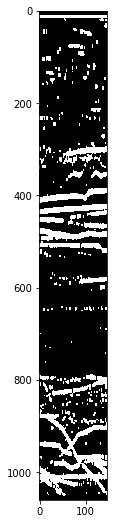

In [170]:
sobel_mask = np.zeros(edge_sobel.shape)
sobel_mask[edge_sobel > 0] = 1

fig2 = figure(2, figsize=(3,9))
ax2 = fig2.add_subplot(1,1,1)
ax2.imshow(sobel_mask, cmap=plt.cm.gray)
show()



# Hough Transform

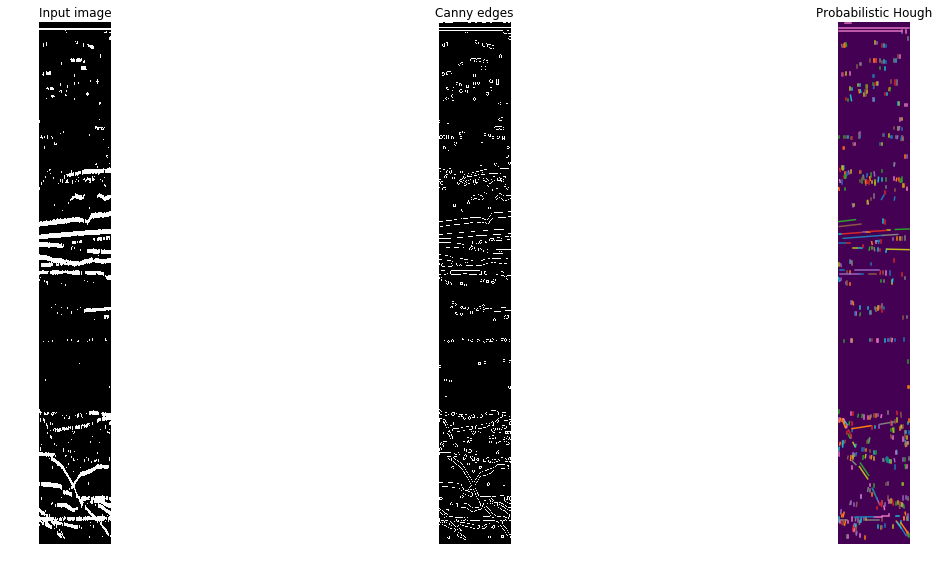

In [118]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
from skimage import data

Trim100m = Sv38kHz.data[:,:np.min(np.where(Sv38kHz.range > 100))]

im = ndi.rotate(Trim100m, -90, mode='constant')

im[im < -70] = -999
im[im > -34] = -999

# Line finding using the Probabilistic Hough Transform
image = im
edges = canny(im, 2, 1, 25)
lines = probabilistic_hough_line(edges, threshold=10, line_length=5,
                                 line_gap=3)

# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=plt.cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

# Blob Detection

In [132]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

Trim100m = Sv38kHz.data[:,:np.min(np.where(Sv38kHz.range > 100))]
im = ndi.rotate(Trim100m, -90, mode='constant')
im[im < -70] = -999
im[im > -34] = -999

image = im
#image_gray = rgb2gray(image)

blobs_log = blob_log(image, max_sigma=30, num_sigma=10, threshold=.1)


In [133]:

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

blobs_dog = blob_dog(image, max_sigma=30, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(image, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)


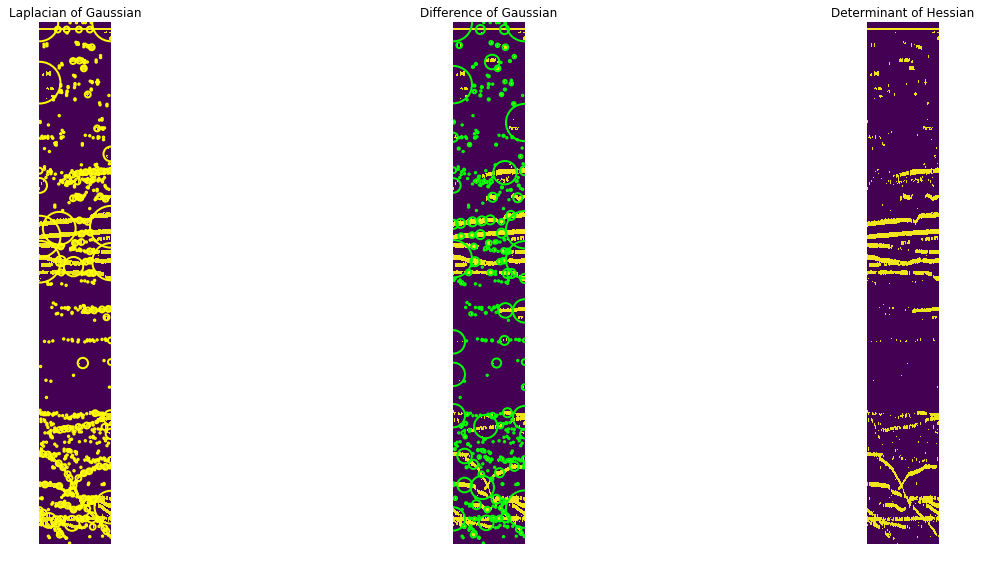

In [134]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

# Angles

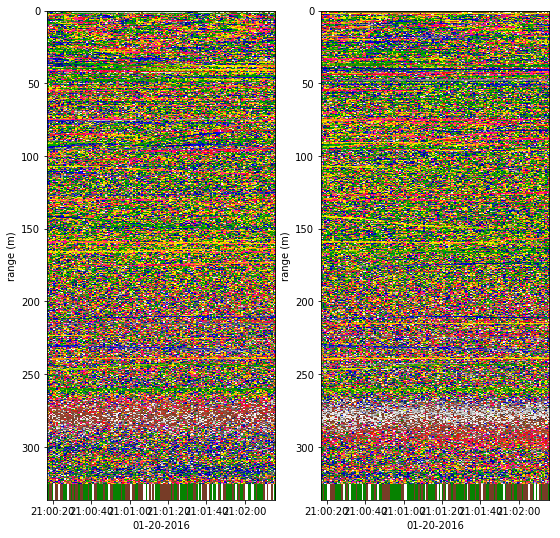

In [199]:
along,athwart=raw38kHz.get_physical_angles()
fig =figure(figsize=(9,9))
#fig = figure()
ax = fig.add_subplot(1,2,1)
echogram_3 = echogram.echogram(ax, along)
ax.grid(False)
ax1 = fig.add_subplot(1,2,2)
echogram_4 = echogram.echogram(ax1, athwart)
ax1.grid(False)
show()

In [202]:
athwart.data

array([[-0.5625  ,  0.      , -0.140625, ...,  0.      ,  0.      ,
         0.      ],
       [-0.5625  , -0.140625, -0.140625, ..., 17.859375, 17.859375,
        17.859375],
       [-0.5625  ,  0.      , -0.140625, ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [-0.5625  ,  0.      , -0.140625, ..., 17.859375, 17.859375,
        17.859375],
       [-0.703125,  0.      , -0.140625, ..., 17.859375, 17.859375,
        17.859375],
       [-0.703125, -0.140625, -0.140625, ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)